# Výpočty foldovacích trajektorií proteinů a korekce jejich potenciálů s využitím Kubernetes a Jupyter Notebooků

## Aleš Křenek, Konference e-Infra CZ, 10.5.2022


# Stále stejná pohádka ...

- Důvodem existence infrastruktury jsou aplikace, které ji používají
- Infrastruktura se má přizpůsobit aplikacím, ne naopak
- Zázraky se nedějí, je třeba držet se reálných možností
- Ukazujeme možnou cestu


- Tato prezentace je několik vydloubaných třešniček z https://github.com/ljocha/chicken-and-egg

# Aplikační problémy a postupy jejich řešení

- Tzv. problém "slepice a vejce" při urychlování simulace foldingu proteinu -- simulaci umíme vést rychle k cíli, známe-li cestu; proč ale hledat cestu, když ji známe? 
- Korekce potenciálů -- empirické potenciály fungují dobře pro simulace proteinů, nepřesné pro malé molekuly (léčiva apod.), je třeba je korigovat s použitím kvantově chemických výpočtů.



- Experimentální, opakovaně modifikované postupy -- Jupyter Notebook je vhodné prostředí
- Některé kroky vyžadují velké softwarové balíky a větší výpočetní zdroje (paměť, CPU, GPU)
- Alokovat je na celou dobu by bylo nepřijatelné plýtvání

In [30]:
import anncolvar

import os
import shutil
from contextlib import redirect_stdout
import re

import concurrent.futures

import numpy as np
import math
from scipy.sparse import coo_matrix,save_npz,load_npz

from pyDOE import lhs
from scipy.sparse.csgraph import shortest_path
from sklearn.manifold import MDS

import PeptideBuilder as pb
import Bio.PDB as pdb
import Bio.SeqUtils as sequtil

import mdtraj as md

import matplotlib.pyplot as plt
import nglview as nv

# from xvg import read_xvg


In [3]:
ncores = 8
ntomp = 2
ntmpi = ncores // ntomp

In [4]:
workdir="/work/1L2Y"
os.chdir(workdir)

# Běžná práce s notebookem

In [5]:
pdbid="1L2Y"
pdbfile=f"{pdbid}.pdb"
m = md.load(pdbfile)
v = nv.show_mdtraj(m)
v.add_representation("licorice")
v

/usr/local/lib/python3.8/dist-packages/mdtraj/formats/pdb/pdbfile.py:200: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


NGLWidget()

In [15]:
nsteps = 12
p = pdb.PDBParser()
instruct = p.get_structure('in',pdbfile)
resl = list(map(lambda r: sequtil.seq1(r.get_resname()),instruct.get_residues()))
nres = len(resl)
out='conf%d.pdb'

itrn = 0
np.random.seed(itrn + 123456789)

phi = lhs(nres - 2, nsteps)
psi = lhs(nres - 2, nsteps)
outf = pdb.PDBIO()

for s in range(nsteps):
    first = pb.Geometry.geometry(resl[0])
    struct = pb.initialize_res(first)
    
    for r in range(1,nres-1):
        if resl[r] == 'P':
            pb.add_residue(struct,resl[r])
        else:
            pb.add_residue(struct,resl[r],phi[s][r-1]*360,psi[2][r-1]*360)
            
    pb.add_residue(struct,resl[nres-1])
        
    fn = out % (itrn * nsteps + s + 1)
    outf.set_structure(struct)
    outf.save(fn)

/usr/local/lib/python3.8/dist-packages/Bio/PDB/Atom.py:232: PDBConstructionWarning: Used element 'H' for Atom (name=H1) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/usr/local/lib/python3.8/dist-packages/Bio/PDB/Atom.py:232: PDBConstructionWarning: Used element 'H' for Atom (name=H2) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/usr/local/lib/python3.8/dist-packages/Bio/PDB/Atom.py:232: PDBConstructionWarning: Used element 'H' for Atom (name=H3) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/usr/local/lib/python3.8/dist-packages/Bio/PDB/Atom.py:232: PDBConstructionWarning: Used element 'H' for Atom (name=HA) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/usr/local/lib/python3.8/dist-packages/Bio/PDB/Atom.py:232: PDBConstructionWarning: Used element 'H' for Atom (name=HB1) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/usr/local/lib/python3.8/dist-packages/Bio/PDB/Atom.py:232: PDBC

In [78]:
!ls -lt conf*pdb | head -12

-rw-r--r-- 1 1001 1002 12482 May  9 08:54 conf12.pdb
-rw-r--r-- 1 1001 1002 12482 May  9 08:54 conf11.pdb
-rw-r--r-- 1 1001 1002 12482 May  9 08:54 conf10.pdb
-rw-r--r-- 1 1001 1002 12482 May  9 08:54 conf9.pdb
-rw-r--r-- 1 1001 1002 12482 May  9 08:54 conf8.pdb
-rw-r--r-- 1 1001 1002 12482 May  9 08:54 conf7.pdb
-rw-r--r-- 1 1001 1002 12482 May  9 08:54 conf6.pdb
-rw-r--r-- 1 1001 1002 12482 May  9 08:54 conf5.pdb
-rw-r--r-- 1 1001 1002 12482 May  9 08:54 conf4.pdb
-rw-r--r-- 1 1001 1002 12482 May  9 08:54 conf3.pdb
-rw-r--r-- 1 1001 1002 12482 May  9 08:54 conf2.pdb
-rw-r--r-- 1 1001 1002 12482 May  9 08:54 conf1.pdb
ls: write error: Broken pipe


In [16]:
tr = md.load([ "conf%d.pdb" % i for i in range(1,nsteps+1)])
idx=tr[0].top.select("name CA")
tr.superpose(tr[0],atom_indices=idx)
v=nv.show_mdtraj(tr)
#v.clear()
v.add_representation("licorice")
v


NGLWidget(max_frame=11)

# Spuštění programu v dalším kontejneru

In [7]:
base='conf1'
gmx=f"/work/gmx-k8s -w {pdbid}"


In [19]:
!{gmx} pdb2gmx -f {base}.pdb -o {base}.gro -p {base} -i {base} -water spce -ff amber99 -ignh
!{gmx} editconf -f {base}.gro -o {base}-box.gro -d 1.5 -bt cubic
!{gmx} grompp -f minim.mdp -c {base}-box.gro -p {base}.top -o {base}-min.tpr -po {base}-min.mdp -maxwarn 1

tr: write error: Broken pipe
tr: write error
job.batch/gmx-zlkg80fxh created
Using the Amber99 force field in directory amber99.ff

going to rename amber99.ff/aminoacids.r2b

going to rename amber99.ff/dna.r2b

going to rename amber99.ff/rna.r2b
Reading conf1.pdb...
Read '', 153 atoms

Analyzing pdb file
Splitting chemical chains based on TER records or chain id changing.

There are 1 chains and 0 blocks of water and 20 residues with 153 atoms

  chain  #res #atoms

  1 'A'    20    153  

All occupancies are one

Reading residue database... (Amber99)

Processing chain 1 'A' (153 atoms, 20 residues)

Identified residue ASN1 as a starting terminus.

Identified residue SER20 as a ending terminus.

Checking for duplicate atoms....

Generating any missing hydrogen atoms and/or adding termini.

Now there are 20 residues with 304 atoms

Making bonds...

Number of bonds was 311, now 310

Generating angles, dihedrals and pairs...

Making cmap torsions...

There are  843 dihedrals,   61 imprope

job.batch "gmx-bv0lt7osc" deleted
tr: write error: Broken pipe
tr: write error
job.batch/gmx-kh42p3216 created
Setting the LD random seed to -59244695

Generated 2145 of the 2145 non-bonded parameter combinations

Generated 2145 of the 2145 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

++++ PLEASE READ AND CITE THE FOLLOWING REFERENCE ++++
J. S. Hub, B. L. de Groot, H. Grubmueller, G. Groenhof
Quantifying Artifacts in Ewald Simulations of Inhomogeneous Systems with a Net
Charge
J. Chem. Theory Comput. 10 (2014) pp. 381-393
-------- -------- --- Thank You --- -------- --------

Analysing residue names:
There are:    20    Protein residues
Analysing Protein...
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 56x56x56, spacing 0.111 0.111 0.111

Estimate for the relative computational load of the PME mesh part: 0.96

This run will generate roughly 2 Mb of data
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

 

In [20]:
!{gmx} mdrun -v -deffnm {base}-min -ntomp 1 -nb cpu -pme cpu

tr: write error: Broken pipe
tr: write error
job.batch/gmx-iemgph3ys created
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Markl

job.batch "gmx-iemgph3ys" deleted


<img src="gmx-k8s.png" width=80%/>

In [21]:
v = nv.show_mdtraj(md.load("conf1-min.trr",top="conf1-min.gro"))
v.add_representation("licorice")
v

NGLWidget(max_frame=263)

# Náročnější výpočet v notebooku

In [25]:
def scale(cores):
    !kubectl scale deployment.apps/chicken-and-egg{os.environ.get('K8S_LABEL')}-placeholder --replicas={cores}

In [26]:
neighs = 5
dims = 2
tr = md.load('landmarks.pdb')
scale(ncores)
# nconf = niter * nsteps
nconf = len(tr)

# compute all-to-all RMSD and select _k_ closest neighbours
row=[]
col=[]
dat=[]

for i in range(nconf):
    d = md.rmsd(tr,tr,frame=i)
    d[range(i+1)] = np.inf
    for _ in range(neighs):
        j = np.argmin(d)
        if d[j] < np.inf:
            row.append(i)
            col.append(j)
            dat.append(d[j])
            row.append(j)
            col.append(i)
            dat.append(d[j])
            d[j] = np.inf

# store results in sparse matrix
dist = coo_matrix((dat,(row,col)),shape=(nconf,nconf)) 
scale(0)

# check sanity
print("conformations (original dimensions): ", nconf)
print("non-zero distances: ", dist.getnnz())

deployment.apps/chicken-and-egg-1l2y-placeholder scaled
deployment.apps/chicken-and-egg-1l2y-placeholder scaled
conformations (original dimensions):  2398
non-zero distances:  23950


In [31]:
save_npz("dist.npz",dist)

In [32]:
dist = load_npz("dist.npz")
scale(ncores)
sp = shortest_path(dist,directed=False)
mds = MDS(n_components=dims,dissimilarity='precomputed',n_jobs=ncores)
emb = mds.fit_transform(sp)
scale(0)

deployment.apps/chicken-and-egg-1l2y-placeholder scaled
deployment.apps/chicken-and-egg-1l2y-placeholder scaled


<img src="scale.png" width=80%/>

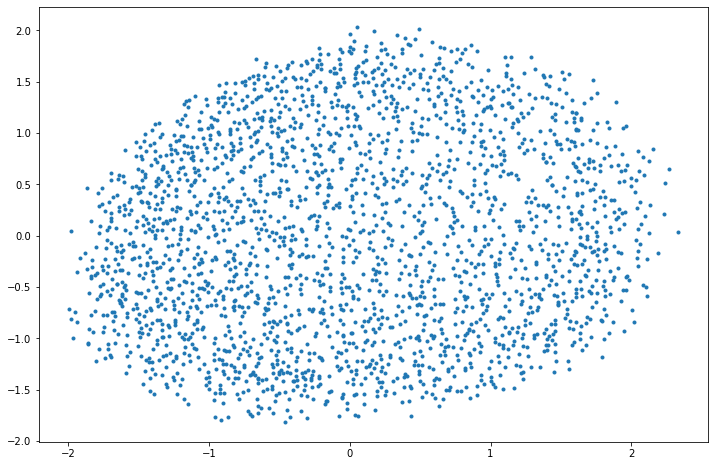

In [33]:
plt.figure(figsize=(12,8))
plt.scatter(*emb.transpose(),marker='.')
plt.show()

# Náročnější výpočet v dalším kontejneru

- Podobně prvnímu příkladu -- výpočet ve vedlejším kontejneru, lze alokovat "libovolné" zdroje (CPU, GPU, RAM)
- O spuštění se stará plánovač K8s
- Déle trvající úlohy mohou být restartovány (např. se staly obětí scale() někoho jiného)
- Je třeba ukládat checkpointy a umět se restartovat

# Výsledky

In [38]:
tr = md.load_xtc("md-ann-pbc.xtc",top='1L2Y.gro')
idx=tr[0].top.select("name CA")
tr.superpose(tr[0],atom_indices=idx)
v = nv.show_mdtraj(tr)
#v.add_representation("licorice")
v

NGLWidget(max_frame=20000)

# Shrnutí

# Poděkování

- Vojtěch Spiwok: zdroj inspirujících problémů
- Vladimír Višňovský: implementace aplikací
- Viktória Spišaková, Lukáš Hejtmánek: budování infrastruktury K8s
- Dalibor Klusáček: netradiční plánování úloh